# Домашнее задание № 8

## Задание 1 (4 балла) 

Обучите 8 моделей для задачи классификации текста (датасет - lenta_40k ). А именно:  
1) модель с 1 GRU слоем;   
2) модель с 1 LSTM слоем    
3) модель с 1 GRU и 1 LSTM слоем  
4) модель с 1 BIGRU и 2 LSTM слоями  
5) модель с 5 GRU слоями и 3 LSTM слоями  
6) модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались   
7) модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM  



Параметр units и размер эмбединга можете задать любой. Оцените качество каждой модели и определите победителя.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

In [3]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pyplot as plt
import torchinfo
%matplotlib inline

In [10]:
data = pd.read_csv("data/lenta_40k.csv.zip")

In [12]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [13]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [14]:
len(vocab)

354611

In [27]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 25:
        filtered_vocab.add(word)

In [28]:
len(filtered_vocab)

27427

In [29]:
# индексируем слова
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

In [30]:
MAX_LEN = 0
MEAN_LEN = 0

for text in data.text:
    text_len = len(preprocess(text))
    MEAN_LEN += text_len
    if text_len > MAX_LEN:
        MAX_LEN = text_len

MEAN_LEN = MEAN_LEN/len(data.text)

In [31]:
MAX_LEN, MEAN_LEN

(1748, 179.99957164757868)

In [32]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, word2id, MAX_LEN, texts, targets):
        

        self.texts = [torch.LongTensor([word2id[w] for w in self.preprocess(t) if w in word2id][:MAX_LEN]) for t in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True)
        
        self.word2id = word2id
        self.MAX_LEN = MAX_LEN
        self.length = len(texts)

        
        self.target = torch.LongTensor(targets)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        ids = self.texts[index]
        y = self.target[index]

        return ids, y
    
    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

In [33]:
MAX_LEN = 250

In [35]:
texts = data.text.values
id2label = {i:l for i,l in enumerate(set(data.topic))}
label2id = {l:i for i,l in id2label.items()}
targets = [label2id[l] for l in data.topic]

In [36]:
train_text, valid_text, train_tar, valid_tar = train_test_split(texts, targets, test_size=0.05)

In [159]:
train_data = Dataset(word2id, MAX_LEN, train_text, train_tar)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=384, shuffle=True, drop_last=True, num_workers=6)

In [160]:
valid_data = Dataset(word2id, MAX_LEN, valid_text, valid_tar)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=384, shuffle=True, drop_last=True, num_workers=6)

In [46]:
from sklearn.metrics import f1_score
from copy import deepcopy


best_f1 = 0;

def train(model, iterator, optimizer, criterion, print_every=1000):
    
    epoch_loss = []
    epoch_f1 = []
    
    model.train()  

    for i, (texts, ys) in enumerate(iterator):
        
        optimizer.zero_grad()   
        predictions = model(texts.to(device)).squeeze()
        loss = criterion(predictions, ys.to(device))        
        
        
        
        loss.backward()
        optimizer.step()     
        preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
        y_true = ys.tolist()
        
        epoch_loss.append(loss.item())
        # хотелось бы все же макро ф-меру, так что мерить будем её
        epoch_f1.append(f1_score(y_true, preds, average="macro"))
        
        if not (i+1) % print_every:
            print(f'Loss: {np.mean(epoch_loss)}; F1 measure: {np.mean(epoch_f1)}')
        
    return np.mean(epoch_f1)


def evaluate(model, iterator, criterion):

    global best_f1
    
    epoch_loss = []
    epoch_f1 = []
    
    model.eval()  
    with torch.no_grad():
        for texts, ys in iterator:   

            predictions = model(texts.to(device)).squeeze()  
            loss = criterion(predictions, ys.to(device))        
            preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            y_true = ys.tolist()
            

            epoch_loss.append(loss.item())  
            f1 = f1_score(y_true, preds, average="macro")
            epoch_f1.append(f1)

            if f1 > best_f1:
                best_f1 = f1
                model.best_state = deepcopy(model.state_dict())
            
    return np.mean(epoch_f1)

### GRU

In [93]:
track_results = {}

In [76]:
class Clf(nn.Module):
    
    def __init__(self, output_dim, *, emb_dim: int = 75, rnn_units: int = 128, debug: bool = False):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = emb_dim
        self.RNN_UNITS = rnn_units
        self.debug = debug
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        
        # все три типа рнн слоев применяются почти одинаково
#         self.rnn = nn.LSTM(self.EMB_DIM, self.RNN_UNITS, batch_first=True)
        self.rnn = nn.GRU(self.EMB_DIM, self.RNN_UNITS, batch_first=True)
#         self.rnn = nn.RNN(self.EMB_DIM, self.RNN_UNITS, batch_first=True)
        self.fc = nn.Sequential(*[nn.Linear(self.RNN_UNITS, output_dim*25),
                                nn.Linear(output_dim*25, output_dim)])
        self.act = nn.LogSoftmax(1) 
        
        
    def forward(self, text):

        embedded = self.embedding(text)
        if self.debug:
            print(embedded.size())
        # применяем rnn слой
        rnn_output, (h, *_) = self.rnn(embedded)
        if self.debug:
            print(rnn_output.size(), )
        
        h = h.squeeze(0)
        
        output = self.act(self.fc(h))        
        return output


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(label2id), emb_dim=75, rnn_units=256)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [77]:
torchinfo.summary(model, input_data=torch.randint(low = 1, high = 5000, size = (256, 250)).to(device))

Layer (type:depth-idx)                   Output Shape              Param #
Clf                                      [256, 19]                 --
├─Embedding: 1-1                         [256, 250, 75]            2,057,100
├─GRU: 1-2                               [256, 250, 256]           255,744
├─Sequential: 1-3                        [256, 19]                 --
│    └─Linear: 2-1                       [256, 475]                122,075
│    └─Linear: 2-2                       [256, 19]                 9,044
├─LogSoftmax: 1-4                        [256, 19]                 --
Total params: 2,443,963
Trainable params: 2,443,963
Non-trainable params: 0
Total mult-adds (G): 16.93
Input size (MB): 0.51
Forward/backward pass size (MB): 170.48
Params size (MB): 9.78
Estimated Total Size (MB): 180.77

In [78]:
best_f1 = 0
f1s = []
f1s_eval = []

for i in range(10):
    print(i)
    f1s.append(train(model, train_loader, optimizer, criterion, 100))
    evl = evaluate(model, valid_loader, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)


0
Loss: 2.3485253167152407; F1 measure: 0.025915597828592637
Eval -  0.03300856770768612
1
Loss: 2.1546674013137816; F1 measure: 0.06201329056021707
Eval -  0.14512048293303687
2
Loss: 1.7114151096343995; F1 measure: 0.17952980553239756
Eval -  0.2139533666656838
3
Loss: 1.3638016831874848; F1 measure: 0.29292629116298985
Eval -  0.3705360172259301
4
Loss: 1.0778276032209397; F1 measure: 0.4213154803852383
Eval -  0.4364458779886188
5
Loss: 0.896014615893364; F1 measure: 0.49422313192746137
Eval -  0.4837727728058038
6
Loss: 0.759537945985794; F1 measure: 0.5550193425732663
Eval -  0.5000944336147433
7
Loss: 0.6336402118206024; F1 measure: 0.6121009657640177
Eval -  0.5259148280677568
8
Loss: 0.5208835971355438; F1 measure: 0.668445102210403
Eval -  0.5583466063917417
9
Loss: 0.4092582681775093; F1 measure: 0.7240283047349009
Eval -  0.568743341869167


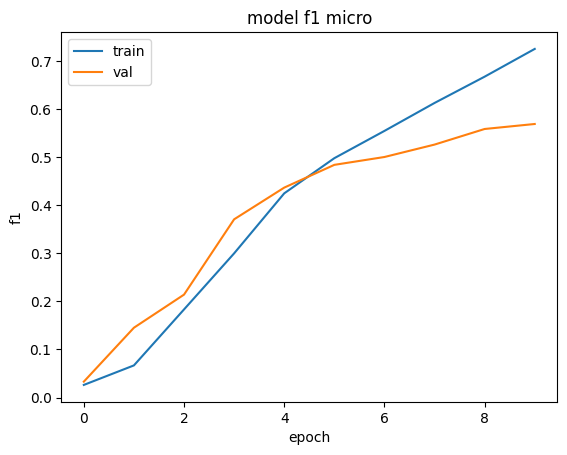

In [79]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [80]:
max(f1s_eval)

0.568743341869167

In [94]:
track_results["GRU"] = max(f1s_eval)

### LSTM

In [87]:
import gc

del model

gc.collect()
torch.cuda.empty_cache()

In [111]:
class Clf(nn.Module):
    
    def __init__(self, output_dim, *, emb_dim: int = 75, rnn_units: int = 128, debug: bool = False):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = emb_dim
        self.RNN_UNITS = rnn_units
        self.debug = debug
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        
        # все три типа рнн слоев применяются почти одинаково
        self.rnn = nn.LSTM(self.EMB_DIM, self.RNN_UNITS, batch_first=True)
#         self.rnn = nn.GRU(self.EMB_DIM, self.RNN_UNITS, batch_first=True)
#         self.rnn = nn.RNN(self.EMB_DIM, self.RNN_UNITS, batch_first=True)
        self.fc = nn.Sequential(*[nn.Linear(self.RNN_UNITS, output_dim*25),
                                nn.Linear(output_dim*25, output_dim)])
        self.act = nn.LogSoftmax(1) 
        
        
    def forward(self, text):

        embedded = self.embedding(text)
        if self.debug:
            print(embedded.size())
        # применяем rnn слой
        rnn_output, (h, *_) = self.rnn(embedded)
        if self.debug:
            print(rnn_output.size(), )
        
        h = h.squeeze(0)
        
        output = self.act(self.fc(h))        
        return output


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(label2id), emb_dim=75, rnn_units=256)
optimizer = optim.Adam(model.parameters(), lr=3e-3)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [112]:
torchinfo.summary(model, input_data=torch.randint(low = 1, high = 5000, size = (256, 250)).to(device))

Layer (type:depth-idx)                   Output Shape              Param #
Clf                                      [256, 19]                 --
├─Embedding: 1-1                         [256, 250, 75]            2,057,100
├─LSTM: 1-2                              [256, 250, 256]           340,992
├─Sequential: 1-3                        [256, 19]                 --
│    └─Linear: 2-1                       [256, 475]                122,075
│    └─Linear: 2-2                       [256, 19]                 9,044
├─LogSoftmax: 1-4                        [256, 19]                 --
Total params: 2,529,211
Trainable params: 2,529,211
Non-trainable params: 0
Total mult-adds (G): 22.38
Input size (MB): 0.51
Forward/backward pass size (MB): 170.48
Params size (MB): 10.12
Estimated Total Size (MB): 181.11

In [113]:
best_f1 = 0
f1s = []
f1s_eval = []

for i in range(15):
    print(i)
    f1s.append(train(model, train_loader, optimizer, criterion, 100))
    evl = evaluate(model, valid_loader, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)


0
Loss: 2.345982828140259; F1 measure: 0.02514825339727632
Eval -  0.02252881372717508
1
Loss: 2.2173854434490203; F1 measure: 0.04442409736733105
Eval -  0.08412875687745691
2
Loss: 1.799983605146408; F1 measure: 0.15273321277322624
Eval -  0.20984946070779054
3
Loss: 1.320700731277466; F1 measure: 0.30032858775684235
Eval -  0.34288008185669694
4
Loss: 1.0080506551265715; F1 measure: 0.42644537199760196
Eval -  0.43058958865180214
5
Loss: 0.7693316864967347; F1 measure: 0.5462316819740805
Eval -  0.47380975618933174
6
Loss: 0.5433116069436074; F1 measure: 0.6519784573862927
Eval -  0.47473108750120696
7
Loss: 0.3442844259738922; F1 measure: 0.7441075394978636
Eval -  0.4909840420821883
8
Loss: 0.21346170149743557; F1 measure: 0.8053003272581378
Eval -  0.5282661586116538
9
Loss: 0.12791574645787476; F1 measure: 0.8716621028621903
Eval -  0.5152283224441205
10
Loss: 0.0878261436894536; F1 measure: 0.9076700552845811
Eval -  0.5180482752765667
11
Loss: 0.05787329450249672; F1 measure: 

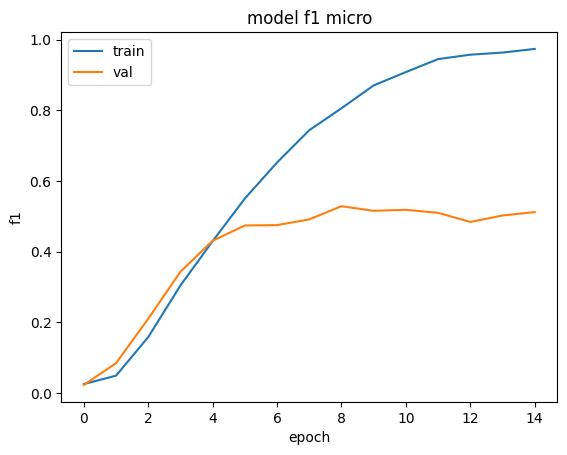

In [114]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [115]:
track_results["LSTM"] = max(f1s_eval)

### 1GRU-1LSTM

In [116]:
import gc

del model

gc.collect()
torch.cuda.empty_cache()

In [117]:
class Clf(nn.Module):
    
    def __init__(self, output_dim, *, emb_dim: int = 75, rnn_units: int = 128, debug: bool = False):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = emb_dim
        self.RNN_UNITS = rnn_units
        self.debug = debug
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        
        
        self.gru = nn.GRU(self.EMB_DIM, self.RNN_UNITS, batch_first=True)
        self.lstm = nn.LSTM(self.RNN_UNITS, self.RNN_UNITS*2, batch_first=True)
        self.fc = nn.Sequential(*[nn.Linear(self.RNN_UNITS*2, output_dim*25),
                                nn.Linear(output_dim*25, output_dim)])
        self.act = nn.LogSoftmax(1) 
        
        
    def forward(self, text):

        embedded = self.embedding(text)
        if self.debug:
            print(embedded.size())
            
        rnn_output, (h, *_) = self.gru(embedded)

        rnn_output, (h, *_) = self.lstm(rnn_output)
        if self.debug:
            print(rnn_output.size(), )
        
        h = h.squeeze(0)
        
        output = self.act(self.fc(h))        
        return output


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(label2id), emb_dim=75, rnn_units=256)
optimizer = optim.AdamW(model.parameters(), lr=0.001)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [118]:
torchinfo.summary(model, input_data=torch.randint(low = 1, high = 5000, size = (256, 250)).to(device))

Layer (type:depth-idx)                   Output Shape              Param #
Clf                                      [256, 19]                 --
├─Embedding: 1-1                         [256, 250, 75]            2,057,100
├─GRU: 1-2                               [256, 250, 256]           255,744
├─LSTM: 1-3                              [256, 250, 512]           1,576,960
├─Sequential: 1-4                        [256, 19]                 --
│    └─Linear: 2-1                       [256, 475]                243,675
│    └─Linear: 2-2                       [256, 19]                 9,044
├─LogSoftmax: 1-5                        [256, 19]                 --
Total params: 4,142,523
Trainable params: 4,142,523
Non-trainable params: 0
Total mult-adds (G): 117.88
Input size (MB): 0.51
Forward/backward pass size (MB): 432.63
Params size (MB): 16.57
Estimated Total Size (MB): 449.71

In [119]:
best_f1 = 0
f1s = []
f1s_eval = []

for i in range(15):
    print(i)
    f1s.append(train(model, train_loader, optimizer, criterion, 100))
    evl = evaluate(model, valid_loader, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)


0
Loss: 2.3457982254028322; F1 measure: 0.025232810782082945
Eval -  0.022850322741943395
1
Loss: 2.1407802736759187; F1 measure: 0.07120789635595785
Eval -  0.1296730040261883
2
Loss: 1.8874345958232879; F1 measure: 0.14276456325036604
Eval -  0.15518837754868384
3
Loss: 1.7204274022579193; F1 measure: 0.18384118677565553
Eval -  0.19960520597395742
4
Loss: 1.5294764459133148; F1 measure: 0.23342348726794288
Eval -  0.2559088415335645
5
Loss: 1.2829206192493439; F1 measure: 0.29813332234517737
Eval -  0.30653037952224677
6
Loss: 1.1072703951597214; F1 measure: 0.3834715147225981
Eval -  0.3754351025351588
7
Loss: 0.9713285821676254; F1 measure: 0.4454786427892285
Eval -  0.41716865285601523
8
Loss: 0.8183906054496766; F1 measure: 0.5176438041567648
Eval -  0.4677468772739662
9
Loss: 0.6899449694156646; F1 measure: 0.5690523877377539
Eval -  0.4665872472628333
10
Loss: 0.5722288754582405; F1 measure: 0.622918984451818
Eval -  0.4959187452891305
11
Loss: 0.45822714507579804; F1 measure:

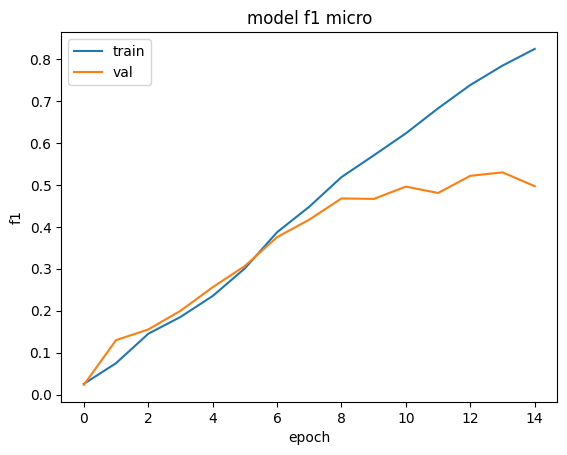

In [120]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [121]:
max(f1s_eval)

0.5298424501870713

In [122]:
track_results["1GRU-1LSTM"] = max(f1s_eval)

### BIGRU-2LSTM

In [164]:
import gc

del model
del criterion
del optimizer

gc.collect()
torch.cuda.empty_cache()

In [165]:
class Clf(nn.Module):
    
    def __init__(self, output_dim, *, emb_dim: int = 75, rnn_units: int = 128, debug: bool = False):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = emb_dim
        self.RNN_UNITS = rnn_units
        self.debug = debug
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        
        
        self.gru = nn.GRU(self.EMB_DIM, self.RNN_UNITS, batch_first=True, bidirectional=True)
        self.lstm = nn.LSTM(self.RNN_UNITS*2, self.RNN_UNITS*2, num_layers=2, batch_first=True)
        self.fc = nn.Sequential(*[nn.Linear(self.RNN_UNITS*2, output_dim*25),
                                nn.Linear(output_dim*25, output_dim)])
        self.act = nn.LogSoftmax(1) 
        
        
    def forward(self, text):

        embedded = self.embedding(text)
        if self.debug:
            print(embedded.size())
            
        rnn_output, (h, *_) = self.gru(embedded)

        rnn_output, (h, *_) = self.lstm(rnn_output)
        if self.debug:
            print(rnn_output.size(), )
        
        h = h.squeeze(0)
        
        output = self.act(self.fc(h[-1]))        
        return output


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(label2id), emb_dim=50, rnn_units=128)
optimizer = optim.AdamW(model.parameters(), lr=3e-3)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [166]:
torchinfo.summary(model, input_data=torch.randint(low = 1, high = 5000, size = (256, 250)).to(device))

Layer (type:depth-idx)                   Output Shape              Param #
Clf                                      [256, 19]                 --
├─Embedding: 1-1                         [256, 250, 50]            1,371,400
├─GRU: 1-2                               [256, 250, 256]           138,240
├─LSTM: 1-3                              [256, 250, 256]           1,052,672
├─Sequential: 1-4                        [256, 19]                 --
│    └─Linear: 2-1                       [256, 475]                122,075
│    └─Linear: 2-2                       [256, 19]                 9,044
├─LogSoftmax: 1-5                        [256, 19]                 --
Total params: 2,693,431
Trainable params: 2,693,431
Non-trainable params: 0
Total mult-adds (G): 76.60
Input size (MB): 0.51
Forward/backward pass size (MB): 288.76
Params size (MB): 10.77
Estimated Total Size (MB): 300.04

In [167]:
best_f1 = 0
f1s = []
f1s_eval = []

for i in range(15):
    print(i)
    f1s.append(train(model, train_loader, optimizer, criterion, 100))
    evl = evaluate(model, valid_loader, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)


0
Loss: 2.349233794212341; F1 measure: 0.023269857257844383
Eval -  0.020956592560024374
1
Loss: 2.0664863979816435; F1 measure: 0.08023940018742716
Eval -  0.17531654071605282
2
Loss: 1.570605366230011; F1 measure: 0.21958919304490768
Eval -  0.24308747686358276
3
Loss: 1.2272375905513764; F1 measure: 0.3032644240188253
Eval -  0.34554106662946316
4
Loss: 0.9677202326059341; F1 measure: 0.40398097645873215
Eval -  0.387285129662066
5
Loss: 0.7658754414319993; F1 measure: 0.5079753742888928
Eval -  0.4493971375243634
6
Loss: 0.5756055095791817; F1 measure: 0.6093859867453397
Eval -  0.511365027268017
7
Loss: 0.43128073334693906; F1 measure: 0.676691510938646
Eval -  0.5283403362699064
8
Loss: 0.3008906497061253; F1 measure: 0.746785812338215
Eval -  0.5004001212414979
9
Loss: 0.22230815269052984; F1 measure: 0.806637835614917
Eval -  0.5171975458367843
10
Loss: 0.16733411349356175; F1 measure: 0.8413474718630581
Eval -  0.5111151892505469
11
Loss: 0.12097762495279313; F1 measure: 0.876

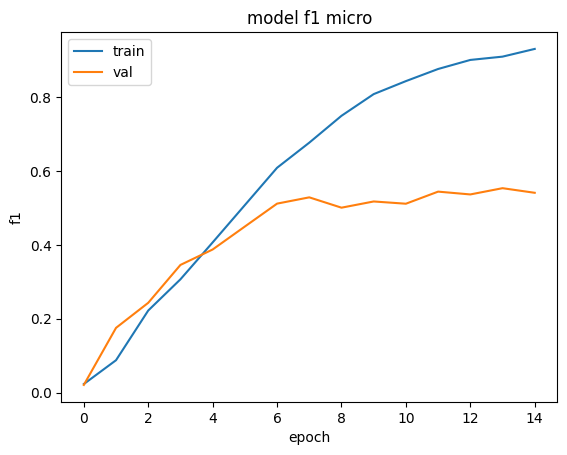

In [170]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [171]:
track_results["BIGRU-2LSTM"] = max(f1s_eval)

### 5GRU-3LSTM

In [189]:
import gc

del model
del criterion
del optimizer

gc.collect()
torch.cuda.empty_cache()

In [190]:
class Clf(nn.Module):
    
    def __init__(self, output_dim, *, emb_dim: int = 75, rnn_units: int = 128, debug: bool = False):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = emb_dim
        self.RNN_UNITS = rnn_units
        self.debug = debug
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        
        
        self.gru = nn.GRU(self.RNN_UNITS*2, self.RNN_UNITS, batch_first=True, num_layers=5)
        self.lstm = nn.LSTM(self.EMB_DIM, self.RNN_UNITS*2, num_layers=3, batch_first=True)
        self.fc = nn.Sequential(*[nn.Linear(self.RNN_UNITS, output_dim*25),
                                nn.Linear(output_dim*25, output_dim)])
        self.act = nn.LogSoftmax(1) 
        
        
    def forward(self, text):

        embedded = self.embedding(text)
        if self.debug:
            print(embedded.size())
            
        rnn_output, (h, *_) = self.lstm(embedded)

        rnn_output, (h, *_) = self.gru(rnn_output)
        if self.debug:
            print(h.size(), )
        
        h = h.squeeze(0)
        
        output = self.act(
            self.fc(
                h
            )
        )        
        return output


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(label2id), emb_dim=50, rnn_units=128)
optimizer = optim.Adam(model.parameters(), lr=3e-3)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [191]:
torchinfo.summary(model, input_data=torch.randint(low = 1, high = 5000, size = (256, 250)).to(device))

Layer (type:depth-idx)                   Output Shape              Param #
Clf                                      [256, 19]                 --
├─Embedding: 1-1                         [256, 250, 50]            1,371,400
├─LSTM: 1-2                              [256, 250, 256]           1,368,064
├─GRU: 1-3                               [256, 250, 128]           544,512
├─Sequential: 1-4                        [256, 19]                 --
│    └─Linear: 2-1                       [256, 475]                61,275
│    └─Linear: 2-2                       [256, 19]                 9,044
├─LogSoftmax: 1-5                        [256, 19]                 --
Total params: 3,354,295
Trainable params: 3,354,295
Non-trainable params: 0
Total mult-adds (G): 122.77
Input size (MB): 0.51
Forward/backward pass size (MB): 223.22
Params size (MB): 13.42
Estimated Total Size (MB): 237.15

In [192]:
best_f1 = 0
f1s = []
f1s_eval = []

for i in range(15):
    print(i)
    f1s.append(train(model, train_loader, optimizer, criterion, 100))
    evl = evaluate(model, valid_loader, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)


0
Loss: 2.348554003238678; F1 measure: 0.023368936717834247
Eval -  0.022682584801927225
1
Loss: 2.3222900080680846; F1 measure: 0.02513435200232046
Eval -  0.022769367252143284
2
Loss: 2.3206348705291746; F1 measure: 0.02534908978139361
Eval -  0.022769646011486233
3
Loss: 2.324558002948761; F1 measure: 0.024181635814044155
Eval -  0.02262767407954347
4
Loss: 2.322609550952911; F1 measure: 0.02429887403904054
Eval -  0.023284581657353358
5
Loss: 2.318810057640076; F1 measure: 0.027222926614536277
Eval -  0.02268452183869294
6
Loss: 2.31958212852478; F1 measure: 0.025865522938796008
Eval -  0.023062569486976527
7
Loss: 2.322669594287872; F1 measure: 0.02379021689867235
Eval -  0.022374932798771546
8
Loss: 2.3223935317993165; F1 measure: 0.023838336691721994
Eval -  0.022333639108520466
9
Loss: 2.32314745426178; F1 measure: 0.025808059037021425
Eval -  0.022575989668398678
10
Loss: 2.3214984798431395; F1 measure: 0.023695990242945452
Eval -  0.022704496758442848
11
Loss: 2.3224566054344

###### На таком количестве слоев без residual connection-ов затухание градиента прявляется уже вовсю

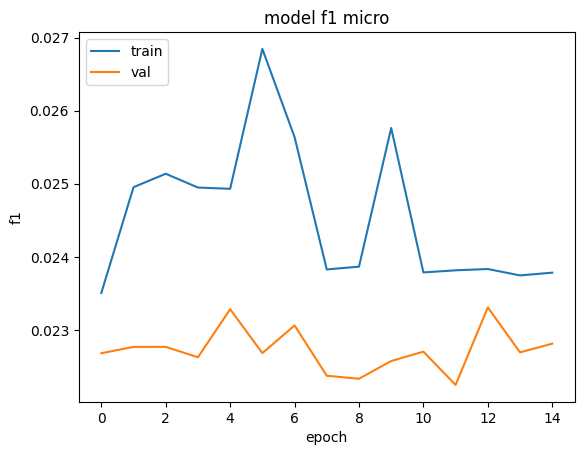

In [193]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [194]:
track_results["5GRU-3LSTM"] = max(f1s_eval)

### 1BIGRU-1BILSTM

In [217]:
import gc

del model
del criterion
del optimizer

gc.collect()
torch.cuda.empty_cache()

In [218]:
class Clf(nn.Module):
    
    def __init__(self, output_dim, *, emb_dim: int = 75, rnn_units: int = 128, debug: bool = False):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = emb_dim
        self.RNN_UNITS = rnn_units
        self.debug = debug
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        
        
        self.gru_f = nn.GRU(self.RNN_UNITS*2, self.RNN_UNITS*3, batch_first=True)
        self.lstm_f = nn.LSTM(self.EMB_DIM, self.RNN_UNITS*2, batch_first=True)

        self.gru_b = nn.GRU(self.RNN_UNITS*2, self.RNN_UNITS*3, batch_first=True)
        self.lstm_b = nn.LSTM(self.EMB_DIM, self.RNN_UNITS*2, batch_first=True)
        
        self.fc = nn.Sequential(*[nn.Linear(self.RNN_UNITS*6, output_dim*25),
                                nn.Linear(output_dim*25, output_dim)])
        self.act = nn.LogSoftmax(1) 
        
        
    def forward(self, text):

        embedded = self.embedding(text)
        embedded_back = torch.flip(embedded, (1, ))
        if self.debug:
            print(embedded.size())
            
        rnn_output, (h, *_) = self.lstm_f(embedded)
        rnn_output, (h, *_) = self.gru_f(rnn_output)
        if self.debug:
            print(h.size(), )

        rnn_output, (hb, *_) = self.lstm_b(embedded_back)
        rnn_output, (hb, *_) = self.gru_f(rnn_output)
        if self.debug:
            print(h.size(), )        
        
        h = h.squeeze(0)
        hb = hb.squeeze(0)
        
        output = self.act(
            self.fc(
                torch.cat([h, hb], 1)
            )
        )        
        return output


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(label2id), emb_dim=50, rnn_units=128)
optimizer = optim.Adam(model.parameters(), lr=3e-3)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [219]:
torchinfo.summary(model, input_data=torch.randint(low = 1, high = 5000, size = (256, 250)).to(device))

Layer (type:depth-idx)                   Output Shape              Param #
Clf                                      [256, 19]                 739,584
├─Embedding: 1-1                         [256, 250, 50]            1,371,400
├─LSTM: 1-2                              [256, 250, 256]           315,392
├─GRU: 1-3                               [256, 250, 384]           739,584
├─LSTM: 1-4                              [256, 250, 256]           315,392
├─GRU: 1-5                               [256, 250, 384]           (recursive)
├─Sequential: 1-6                        [256, 19]                 --
│    └─Linear: 2-1                       [256, 475]                365,275
│    └─Linear: 2-2                       [256, 19]                 9,044
├─LogSoftmax: 1-7                        [256, 19]                 --
Total params: 3,855,671
Trainable params: 3,855,671
Non-trainable params: 0
Total mult-adds (G): 135.48
Input size (MB): 0.51
Forward/backward pass size (MB): 681.97
Params size (MB

In [220]:
best_f1 = 0
f1s = []
f1s_eval = []

for i in range(15):
    print(i)
    f1s.append(train(model, train_loader, optimizer, criterion, 100))
    evl = evaluate(model, valid_loader, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)


0
Loss: 2.099803853034973; F1 measure: 0.1406705287235777
Eval -  0.2854571509850581
1
Loss: 1.161636699438095; F1 measure: 0.4225261431609517
Eval -  0.48686616773698577
2
Loss: 0.7648423200845719; F1 measure: 0.5868777043357855
Eval -  0.6000750922090137
3
Loss: 0.5386481937766076; F1 measure: 0.6929828112141132
Eval -  0.6326943518010333
4
Loss: 0.3489121516048908; F1 measure: 0.7839849714669367
Eval -  0.6333200007338251
5
Loss: 0.17041654616594315; F1 measure: 0.9054786342415632
Eval -  0.633290438849144
6
Loss: 0.09340332940220833; F1 measure: 0.9368834709435019
Eval -  0.639620360674622
7
Loss: 0.05041743582114577; F1 measure: 0.9666480626343634
Eval -  0.6190493550309697
8
Loss: 0.05493856450542808; F1 measure: 0.9626148518440012
Eval -  0.6036681036975441
9
Loss: 0.04775770617648959; F1 measure: 0.9679107379689459
Eval -  0.6259280757288231
10
Loss: 0.0325341927818954; F1 measure: 0.9773547647080345
Eval -  0.6268170266891933
11
Loss: 0.0359656529687345; F1 measure: 0.97614365

###### На таком количестве слоев без residual connection-ов затухание градиента прявляется уже вовсю

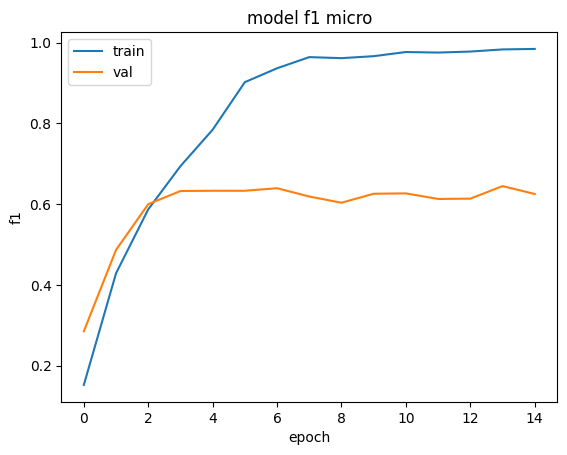

In [221]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [222]:
track_results["1BIGRU-1BILSTM"] = max(f1s_eval)

### LSTM, GRU, BILSTM, BIGRU, GRU, LSTM

In [223]:
import gc

del model
del criterion
del optimizer

gc.collect()
torch.cuda.empty_cache()

In [224]:
class Clf(nn.Module):
    
    def __init__(self, output_dim, *, emb_dim: int = 75, rnn_units: int = 128, debug: bool = False):
        
        super().__init__()          
        self.VOCAB_SIZE = len(word2id)
        self.EMB_DIM = emb_dim
        self.RNN_UNITS = rnn_units
        self.debug = debug
        
        
        self.embedding = nn.Embedding(self.VOCAB_SIZE, self.EMB_DIM)
        
        
        self.gru_f = nn.GRU(self.RNN_UNITS*2, self.RNN_UNITS*3, batch_first=True)
        self.lstm_f = nn.LSTM(self.EMB_DIM, self.RNN_UNITS*2, batch_first=True)

        self.bilstm = nn.LSTM(self.RNN_UNITS*3, int(self.RNN_UNITS*0.5), bidirectional=True, batch_first=True)
        self.bigru = nn.GRU(self.RNN_UNITS, int(self.RNN_UNITS*0.5), bidirectional=True, batch_first=True)
        
        self.gru_l = nn.GRU(self.RNN_UNITS, self.RNN_UNITS*3, batch_first=True)
        self.lstm_l = nn.LSTM(self.RNN_UNITS*3, self.RNN_UNITS, batch_first=True)
        
        self.fc = nn.Linear(self.RNN_UNITS, output_dim)
        self.act = nn.LogSoftmax(1) 
        
        
    def forward(self, text):

        embedded = self.embedding(text)
        if self.debug:
            print(embedded.size())
            
        rnn_output, (h, *_) = self.lstm_f(embedded)
        rnn_output, (h, *_) = self.gru_f(rnn_output)
        if self.debug:
            print(h.size(), )

        rnn_output, (h, *_) = self.bilstm(rnn_output)
        if self.debug:
            print(rnn_output.size(),h.size())        
            
        rnn_output, (h, *_) = self.bigru(rnn_output)
        if self.debug:
            print(rnn_output.size(),h.size())   

        rnn_output, (h, *_) = self.gru_l(rnn_output)
        rnn_output, (h, *_) = self.lstm_l(rnn_output)
        
        h = h.squeeze(0)
        
        output = self.act(
            self.fc(
                h
            )
        )        
        return output


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = Clf(len(label2id), emb_dim=50, rnn_units=128)
optimizer = optim.Adam(model.parameters(), lr=3e-3)
criterion = nn.NLLLoss() 
model = model.to(device)
criterion = criterion.to(device)

In [225]:
torchinfo.summary(model, input_data=torch.randint(low = 1, high = 5000, size = (256, 250)).to(device))

Layer (type:depth-idx)                   Output Shape              Param #
Clf                                      [256, 19]                 --
├─Embedding: 1-1                         [256, 250, 50]            1,371,400
├─LSTM: 1-2                              [256, 250, 256]           315,392
├─GRU: 1-3                               [256, 250, 384]           739,584
├─LSTM: 1-4                              [256, 250, 128]           230,400
├─GRU: 1-5                               [256, 250, 128]           74,496
├─GRU: 1-6                               [256, 250, 384]           592,128
├─LSTM: 1-7                              [256, 250, 128]           263,168
├─Linear: 1-8                            [256, 19]                 2,451
├─LogSoftmax: 1-9                        [256, 19]                 --
Total params: 3,589,019
Trainable params: 3,589,019
Non-trainable params: 0
Total mult-adds (G): 142.12
Input size (MB): 0.51
Forward/backward pass size (MB): 746.53
Params size (MB): 14

In [226]:
best_f1 = 0
f1s = []
f1s_eval = []

for i in range(15):
    print(i)
    f1s.append(train(model, train_loader, optimizer, criterion, 100))
    evl = evaluate(model, valid_loader, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)


0
Loss: 2.3434873962402345; F1 measure: 0.023236207083838577
Eval -  0.022301651173721883
1
Loss: 2.3245528078079225; F1 measure: 0.02383825737230063
Eval -  0.023264621805767872
2
Loss: 2.2903016924858095; F1 measure: 0.04129319927592787
Eval -  0.0766328975796737
3
Loss: 1.924947201013565; F1 measure: 0.11143651820929773
Eval -  0.20162507196755128
4
Loss: 1.4952860748767853; F1 measure: 0.24034379972880213
Eval -  0.28234885907316126
5
Loss: 1.223235728740692; F1 measure: 0.3330918065721649
Eval -  0.36601765610387665
6
Loss: 1.009773878455162; F1 measure: 0.4169037966049688
Eval -  0.40516910430362574
7
Loss: 0.8489559972286225; F1 measure: 0.4769623881002981
Eval -  0.43823573181438613
8
Loss: 0.7332448369264603; F1 measure: 0.5336765144912614
Eval -  0.4638029671766283
9
Loss: 0.62161641985178; F1 measure: 0.5830049870972828
Eval -  0.4681599118263879
10
Loss: 0.5413086724281311; F1 measure: 0.6267069337486061
Eval -  0.4728116733537181
11
Loss: 0.4615032270550728; F1 measure: 0.

###### На таком количестве слоев без residual connection-ов затухание градиента прявляется уже вовсю

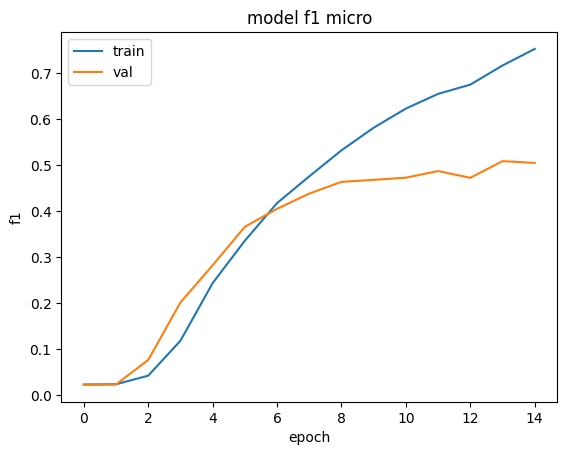

In [227]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [228]:
track_results["LSTM, GRU, BILSTM, BIGRU, GRU, LSTM"] = max(f1s_eval)

In [229]:
track_results

{'GRU': 0.568743341869167,
 'LSTM': 0.5282661586116538,
 '1GRU-1LSTM': 0.5298424501870713,
 'BIGRU-2LSTM': 0.5531269545620703,
 '5GRU-3LSTM': 0.023309755203228772,
 '1BIGRU-1BILSTM': 0.6448696552477688,
 'LSTM, GRU, BILSTM, BIGRU, GRU, LSTM': 0.5088487917067253}

Все таки stack more layers не настолько универсальный принцип. Можно было бы еще поиграть с гиперпараметрами и размерностью слоев, или опять же взять предобученные эмбединги, и обучать только слои. Но 64 на macro f1 в целом тоже довольно неплохо!

## Задание 2 (6 баллов)


На данных википедии (wikiann) обучите 2 модели:  
1) модель в которой будут использованы предобученные эмбединги слов и несколько BILSTM слоев. 
1) модель в которой будут использованы предобученные эмбединги слов и несколько BIGRU слоев. 

Сравните качество по метрикам. Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.

In [1]:
import datasets

In [4]:
dataset = datasets.load_dataset("wikiann", "ru")

In [5]:
dataset

DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 20000
    })
})

In [48]:
dataset["train"]["ner_tags"][2]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0]

In [12]:
id2labels = {0:'O', 1:'B-PER', 2:'I-PER', 3:'B-ORG', 4:'I-ORG', 5: 'B-LOC', 6:'I-LOC', 7:'PAD'}
label2id = {v:k for k,v in id2labels.items()} 

In [108]:
import gensim

model = gensim.models.KeyedVectors.load("models_rnn/model.model")

In [13]:
dataset["train"]

Dataset({
    features: ['tokens', 'ner_tags', 'langs', 'spans'],
    num_rows: 20000
})

In [193]:
from pymorphy3 import MorphAnalyzer

morph = MorphAnalyzer()

In [197]:
morph.parse("стекло")[0].normal_form

'стекло'

In [222]:


class Dataset(torch.utils.data.Dataset):

    def __init__(self, vocab_model, texts, targets):
        

        self.texts = [torch.LongTensor([model.key_to_index[self.preprocess(t.lower())] if self.preprocess(t.lower()) in model.key_to_index else 0 for t in text]) 
                      for text in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True)
        
        self.length = len(texts)

        
        self.target = [torch.LongTensor(target) for target in targets]
        self.target = torch.nn.utils.rnn.pad_sequence(self.target, batch_first=True)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        ids = self.texts[index]
        y = self.target[index]

        return ids, y
    
    def preprocess(self, text):
        tokens = morph.parse(text)[0].normal_form
        return tokens

In [223]:
train_data = Dataset(model,texts = dataset["train"]["tokens"], targets=dataset["train"]["ner_tags"])
test_data = Dataset(model, texts = dataset["validation"]["tokens"], targets=dataset["validation"]["ner_tags"])

In [224]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, num_workers=8, drop_last=True, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=128, num_workers=8, drop_last=True, shuffle=True)

In [225]:
OUTPUT_CLASSES = len(id2labels)-1

OUTPUT_CLASSES

7

In [226]:
def train(model, iterator, optimizer, criterion, print_every=1000):
    
    epoch_loss = []
    model.train()  

    for i, (texts, ys) in enumerate(iterator):
        
        optimizer.zero_grad()   
        predictions = model(texts.to(device))
        loss = criterion(predictions.permute(0, 2, 1), ys.to(device))
        
        loss.backward()
        optimizer.step()     
        preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
        y_true = ys.tolist()
        
        epoch_loss.append(loss.item())
        
        if not (i+1) % print_every:
            print(f'Loss: {np.mean(epoch_loss)}')
        
    return np.mean(epoch_loss)


def evaluate(model, iterator, criterion):
    
    epoch_loss = []
    
    model.eval()  
    with torch.no_grad():
        for texts, ys in iterator:   
            
            predictions = model(texts.to(device)).squeeze()  
            loss = criterion(predictions.permute(0, 2, 1), ys.to(device))        
            preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            y_true = ys.tolist()
            

            epoch_loss.append(loss.item())
            
    return np.mean(epoch_loss)

In [236]:
class Clf(nn.Module):
    
    def __init__(self, output_dim, *, emb_model, emb_dim: int = 300, rnn_units: int = 128, debug: bool = False):
        
        super().__init__()          
        self.RNN_UNITS = rnn_units
        self.EMB_SIZE = emb_dim
        self.debug = debug

        self.emb = nn.Embedding(model.vectors.shape[0], model.vectors.shape[1], _weight=torch.FloatTensor(model.vectors))
        
        self.lstm = nn.LSTM(self.EMB_SIZE, self.RNN_UNITS*2, bidirectional = True, num_layers = 2 , batch_first=True)
        
        self.fc = nn.Sequential(*[nn.Linear(self.RNN_UNITS*4, output_dim*8),
                                 nn.Linear(output_dim*8, output_dim)])
        self.act = nn.LogSoftmax(2) 
        
        
    def forward(self, x):

        emb = self.emb(x)
        if self.debug:
            print(emb.size())
            
        rnn_output, (h, *_) = self.lstm(emb)

        if self.debug:
            print(h.size(), )
                
        output = self.act(
            self.fc(
                rnn_output
            )
        )        
        return output


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
cls = Clf(len(label2id), emb_model = model, emb_dim=300, rnn_units=128)
optimizer = optim.Adam(cls.parameters(), lr=3e-3)
criterion = nn.NLLLoss() 
cls = cls.to(device)
criterion = criterion.to(device)

### Как-то  многовато параметров из-за размера словаря. Эмбединги учить не будем

In [237]:
torchinfo.summary(cls, input_data=next(iter(train_loader))[0].to(device))

Layer (type:depth-idx)                   Output Shape              Param #
Clf                                      [128, 54, 8]              --
├─Embedding: 1-1                         [128, 54, 300]            104,188,500
├─LSTM: 1-2                              [128, 54, 512]            2,719,744
├─Sequential: 1-3                        [128, 54, 8]              --
│    └─Linear: 2-1                       [128, 54, 64]             32,832
│    └─Linear: 2-2                       [128, 54, 8]              520
├─LogSoftmax: 1-4                        [128, 54, 8]              --
Total params: 106,941,596
Trainable params: 106,941,596
Non-trainable params: 0
Total mult-adds (G): 32.14
Input size (MB): 0.06
Forward/backward pass size (MB): 48.88
Params size (MB): 427.77
Estimated Total Size (MB): 476.70

In [238]:
cls.emb.requires_grad_=False

In [239]:
losses = []
losses_eval = []

for i in range(15):
    print(i)
    losses.append(train(cls, train_loader, optimizer, criterion, 30))
    losses_eval.append(evaluate(cls, test_loader, criterion))

0
Loss: 0.34526702811320625
Loss: 0.24039126187562943
Loss: 0.18994657380713356
Loss: 0.16046173817788562
Loss: 0.14113051553567252
1
Loss: 0.05008520657817523
Loss: 0.048629333078861234
Loss: 0.047978338681989245
Loss: 0.04700343543663621
Loss: 0.04630640499293804
2
Loss: 0.030775568696359792
Loss: 0.03093121889978647
Loss: 0.03127537357310454
Loss: 0.030928503659864267
Loss: 0.031248531093200048
3
Loss: 0.02335734755421678
Loss: 0.02386017081638177
Loss: 0.02388913341694408
Loss: 0.02389810956083238
Loss: 0.02397181895871957
4
Loss: 0.017553997288147608
Loss: 0.018300579596931734
Loss: 0.018410681602027683
Loss: 0.018963951524347065
Loss: 0.01933977302784721
5
Loss: 0.015292064504077036
Loss: 0.016007158913028736
Loss: 0.016239882276083032
Loss: 0.016287796676624566
Loss: 0.016343174722666543
6
Loss: 0.012821750544632474
Loss: 0.014195959324327607
Loss: 0.014293292263108824
Loss: 0.014129158190917224
Loss: 0.014178775108108917
7
Loss: 0.01224648926096658
Loss: 0.012124089772502582
Lo

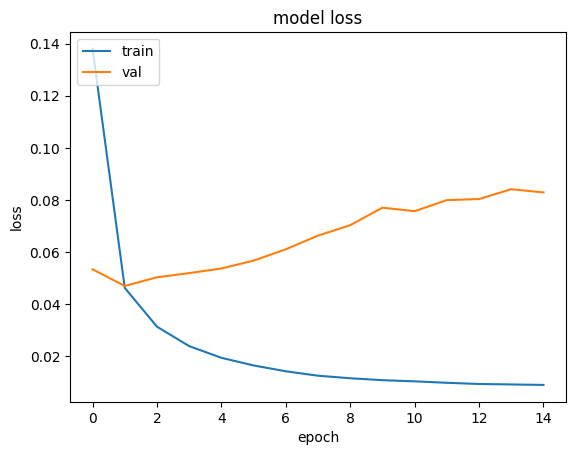

In [240]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Validation

In [241]:
val_data = Dataset(model,texts = dataset["test"]["tokens"], targets=dataset["test"]["ner_tags"])

In [242]:
val_loader = torch.utils.data.DataLoader(val_data, batch_size=128, num_workers=8, drop_last=True, shuffle=True)

In [243]:
from sklearn.metrics import classification_report

In [245]:
preds = []

for xs, ys in val_loader:

    cls.eval()

    with torch.no_grad():

        predictions = cls(xs.to(device)).squeeze().argmax(2).detach().to("cpu").tolist()

        preds.extend(predictions)

#### хм, результаты не очень -- хотя уже по графику лосса было понятно, что мы скорее переобучаемся, чем учимся. Возможно, можно было бы попробовать обрезать матрицу весов только под имеющиеся токены, но попробуем на GRU -- без особых надежд

In [246]:
print(classification_report(val_data.target[:9984, :].reshape(-1), np.array(preds).reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

           O       0.97      0.97      0.97    588285
       B-PER       0.15      0.16      0.15      3536
       I-PER       0.20      0.21      0.20      7532
       B-ORG       0.07      0.06      0.06      4067
       I-ORG       0.11      0.10      0.11      7983
       B-LOC       0.04      0.04      0.04      4556
       I-LOC       0.04      0.04      0.04      3049
         PAD       0.00      0.00      0.00         0

   micro avg       0.93      0.93      0.93    619008
   macro avg       0.20      0.20      0.20    619008
weighted avg       0.93      0.93      0.93    619008



In [252]:
class Clf(nn.Module):
    
    def __init__(self, output_dim, *, emb_model, emb_dim: int = 300, rnn_units: int = 128, debug: bool = False):
        
        super().__init__()          
        self.RNN_UNITS = rnn_units
        self.EMB_SIZE = emb_dim
        self.debug = debug

        self.emb = nn.Embedding(model.vectors.shape[0], model.vectors.shape[1], _weight=torch.FloatTensor(model.vectors))
        
        self.gru = nn.GRU(self.EMB_SIZE, self.RNN_UNITS*3, bidirectional = True, num_layers = 2 , batch_first=True)
        
        self.fc = nn.Sequential(*[nn.Linear(self.RNN_UNITS*6, output_dim*250),
                                 nn.Linear(output_dim*250, output_dim)])
        self.act = nn.LogSoftmax(2) 
        
        
    def forward(self, x):

        emb = self.emb(x)
        if self.debug:
            print(emb.size())
            
        rnn_output, (h, *_) = self.gru(emb)

        if self.debug:
            print(h.size(), )
                
        output = self.act(
            self.fc(
                rnn_output
            )
        )        
        return output


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
cls = Clf(len(label2id), emb_model = model, emb_dim=300, rnn_units=128)
optimizer = optim.Adam(cls.parameters(), lr=3e-3)
criterion = nn.NLLLoss() 
cls = cls.to(device)
criterion = criterion.to(device)

In [253]:
torchinfo.summary(cls, input_data=next(iter(train_loader))[0].to(device))

Layer (type:depth-idx)                   Output Shape              Param #
Clf                                      [128, 54, 8]              --
├─Embedding: 1-1                         [128, 54, 300]            104,188,500
├─GRU: 1-2                               [128, 54, 768]            4,239,360
├─Sequential: 1-3                        [128, 54, 8]              --
│    └─Linear: 2-1                       [128, 54, 2000]           1,538,000
│    └─Linear: 2-2                       [128, 54, 8]              16,008
├─LogSoftmax: 1-4                        [128, 54, 8]              --
Total params: 109,981,868
Trainable params: 109,981,868
Non-trainable params: 0
Total mult-adds (G): 42.84
Input size (MB): 0.06
Forward/backward pass size (MB): 170.09
Params size (MB): 439.93
Estimated Total Size (MB): 610.07

In [254]:
cls.emb.requires_grad_=False

In [255]:
losses = []
losses_eval = []

for i in range(15):
    print(i)
    losses.append(train(cls, train_loader, optimizer, criterion, 30))
    losses_eval.append(evaluate(cls, test_loader, criterion))

0
Loss: 1.9670431037743887
Loss: 1.1393298834562302
Loss: 0.8152722743650277
Loss: 0.6426458303506176
Loss: 0.534656392087539
1
Loss: 0.08159230835735798
Loss: 0.07762195840477944
Loss: 0.07419273861580425
Loss: 0.07363877451668183
Loss: 0.07168713117639224
2
Loss: 0.044241732855637865
Loss: 0.04377958870803316
Loss: 0.04463652378569047
Loss: 0.04457973053989311
Loss: 0.04464981122563283
3
Loss: 0.032788883335888384
Loss: 0.03226761591310302
Loss: 0.032010580019818415
Loss: 0.03281458024866879
Loss: 0.03281889428695043
4
Loss: 0.03087038410206636
Loss: 0.028822211921215056
Loss: 0.027759334972749152
Loss: 0.028277631018621227
Loss: 0.027761676566054425
5
Loss: 0.021615103942652543
Loss: 0.02151443320326507
Loss: 0.021706956811249255
Loss: 0.022068916245674093
Loss: 0.022321843535949785
6
Loss: 0.01799820363521576
Loss: 0.01825715188557903
Loss: 0.019250599046548206
Loss: 0.019117150463474293
Loss: 0.019411806898812452
7
Loss: 0.016065910644829273
Loss: 0.015783517481759192
Loss: 0.0160

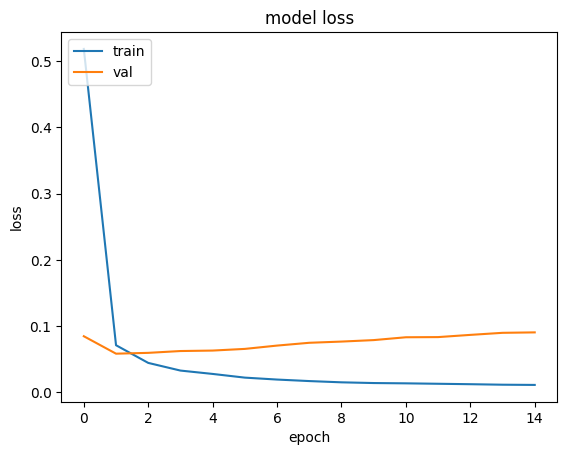

In [259]:
plt.plot(losses)
plt.plot(losses_eval)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Validation

In [257]:
preds = []

for xs, ys in val_loader:

    cls.eval()

    with torch.no_grad():

        predictions = cls(xs.to(device)).squeeze().argmax(2).detach().to("cpu").tolist()

        preds.extend(predictions)

#### Без дообучения эмбедингов добиться высокого качества тут явно не выйдет. 

In [258]:
print(classification_report(val_data.target[:9984, :].reshape(-1), np.array(preds).reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

           O       0.97      0.97      0.97    588285
       B-PER       0.16      0.17      0.17      3536
       I-PER       0.21      0.20      0.21      7532
       B-ORG       0.07      0.06      0.06      4067
       I-ORG       0.11      0.10      0.10      7983
       B-LOC       0.04      0.04      0.04      4556
       I-LOC       0.04      0.03      0.04      3049
         PAD       0.00      0.00      0.00         0

   micro avg       0.93      0.93      0.93    619008
   macro avg       0.20      0.20      0.20    619008
weighted avg       0.93      0.93      0.93    619008



In [268]:
def get_indices(text:str):
    def preprocess(text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

    return torch.LongTensor([model.key_to_index[morph.parse(t)[0].normal_form] if morph.parse(t)[0].normal_form in model.key_to_index else 0 for t in preprocess(text)])

In [275]:
gc.collect()
torch.cuda.empty_cache()

In [270]:
text = "Иван Иванович приехал в Липецк скорее случайно, чем специально."

In [281]:
preds = cls(get_indices(text).unsqueeze(0).to(device)).argmax(2).detach().to("cpu")

In [293]:

print(*map(lambda x: id2labels[x], preds.tolist()[0]))

B-PER I-PER O O O O O O O


#### Вообще довольно неудивительно, что на локациях стабильные ошибки -- многих из них может просто не быть в словаре, а где они есть, то встречаются довольно редко для формирования качественного эмбединга

In [294]:
text = "Карл Фридрих Иероним фон Мюнхгаузен родился в Боденвердере"

In [295]:
preds = cls(get_indices(text).unsqueeze(0).to(device)).argmax(2).detach().to("cpu")

In [296]:

print(*map(lambda x: id2labels[x], preds.tolist()[0]))

B-PER I-PER I-PER I-PER O O O O
